# Breast cancer circulating tumour cell classification

## 2.2. Support Vector Machines

Importing necessary libraries

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, csc_matrix
plt.style.use('default')
import joblib

# scikit-learn
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import RocCurveDisplay, balanced_accuracy_score, PrecisionRecallDisplay, roc_auc_score, accuracy_score, make_scorer, classification_report, ConfusionMatrixDisplay

## Import CTC training and validation data

In [3]:
store = pd.HDFStore(os.path.join(os.pardir, 'data', 'ctc_split_datasets.h5'), mode='r')

X_train, X_valid = store["X_train"], store["X_valid"]
y_train, y_valid = store["y_train"], store["y_valid"]

store.close()
del store

View information about the data

In [4]:
X_train.info(), X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230 entries, BRx_42_1_10_20_CTC_jor to X245_CTC_mar
Columns: 52762 entries, ENSG00000223972.5 to ENSG00000210196.2
dtypes: float64(48523), int64(4239)
memory usage: 92.6+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, Brx116_1_SC1_092414_CTC_ebr to BRx_82_1_9_29_CTC_jor
Columns: 52762 entries, ENSG00000223972.5 to ENSG00000210196.2
dtypes: float64(48523), int64(4239)
memory usage: 16.1+ MB


(None, None)

In [5]:
y_train.info(), y_valid.info()

<class 'pandas.core.series.Series'>
Index: 230 entries, BRx_42_1_10_20_CTC_jor to X245_CTC_mar
Series name: state
Non-Null Count  Dtype
--------------  -----
230 non-null    int64
dtypes: int64(1)
memory usage: 3.6+ KB
<class 'pandas.core.series.Series'>
Index: 40 entries, Brx116_1_SC1_092414_CTC_ebr to BRx_82_1_9_29_CTC_jor
Series name: state
Non-Null Count  Dtype
--------------  -----
40 non-null     int64
dtypes: int64(1)
memory usage: 640.0+ bytes


(None, None)

Convert gene data into a sparse matrix to reduce memory and improve performance

In [6]:
X_train_csc = csc_matrix(X_train.values.astype(np.float32))
X_train_csc

<230x52762 sparse matrix of type '<class 'numpy.float32'>'
	with 1248558 stored elements in Compressed Sparse Column format>

In [7]:
X_train_csr = X_train_csc.tocsr()
X_train_csr

<230x52762 sparse matrix of type '<class 'numpy.float32'>'
	with 1248558 stored elements in Compressed Sparse Row format>

In [8]:
X_valid_csr = csr_matrix(X_valid.astype(np.float32))
X_valid_csr

<40x52762 sparse matrix of type '<class 'numpy.float32'>'
	with 216275 stored elements in Compressed Sparse Row format>

### Results functions
Define functions to measure model training and validation results

In [9]:
"""
    Prints and displays metrics used to evaluate the model.
"""
def classifier_results(classifier_name:str, dataset_name:str, y, y_pred, y_pred_proba) -> None:    

    print(f"Mean accuracy ({dataset_name}):", accuracy_score(y, y_pred))
    print(f"Mean balanced accuracy({dataset_name}): ", balanced_accuracy_score(y, y_pred))
    print(f"Mean roc auc({dataset_name}): ", roc_auc_score(y, y_pred_proba))
    
    
    RocCurveDisplay.from_predictions(y, y_pred_proba, plot_chance_level=True, drop_intermediate=False)
    plt.title(f"{classifier_name} ROC Curve {dataset_name}")
    plt.show()
    
    PrecisionRecallDisplay.from_predictions(y, y_pred_proba, plot_chance_level=True, drop_intermediate=False)
    plt.title(f"{classifier_name} Precision Recall Curve {dataset_name}")
    plt.show()
    
    ConfusionMatrixDisplay.from_predictions(y, y_pred)
    plt.title(f"{classifier_name} Confusion Matrix {dataset_name}")
    plt.show()
    
    print(classification_report(y, y_pred))


"""
    Trains, validates and displays results of a DNN model with provided estimator(model).
"""
def svc_classifier_results_from_estimator(estimator) -> None:
    svc = estimator
    
    y_train_pred = svc.predict(X_train_csr)
    y_train_pred_proba = svc.predict_proba(X_train_csr)[:,1]
    
    y_valid_pred = svc.predict(X_valid_csr)
    y_valid_pred_proba = svc.predict_proba(X_valid_csr)[:,1]
    
    classifier_results("Support Vector Machine", "Training", y_train, y_train_pred, y_train_pred_proba)
    classifier_results("Support Vector Machine", "Validation", y_valid, y_valid_pred, y_valid_pred_proba)

"""
    Creates, trains, validates and displays results of a DNN model with provided params.
    Returns the model.
""" 
def svc_classifier_results(params) -> SVC:
    svc = SVC(**params)
    svc.fit(X_train_csc, y_train)
        
    
    y_train_pred = svc.predict(X_train_csr)
    y_train_pred_proba = svc.predict_proba(X_train_csr)[:,1]
    
    y_valid_pred = svc.predict(X_valid_csr)
    y_valid_pred_proba = svc.predict_proba(X_valid_csr)[:,1]
    
    classifier_results("Support Vector Machine", "Training", y_train, y_train_pred, y_train_pred_proba)
    classifier_results("Support Vector Machine", "Validation", y_valid, y_valid_pred, y_valid_pred_proba)
    
    return svc

## Define functions using Grid Search Cross-Validation

Define the parameters that divide the samples so that they are always drawn identically

In [10]:
random_state = 0
rng = np.random.RandomState(random_state)
cv_kFold = KFold(n_splits=7, shuffle=True, random_state=random_state)

Define functions to perform Grid Search CV based on model parameters

In [11]:
"""
    Conducts grid search for cross-validation on the training dataset with given parameters for search and model.
    Prints classification results for training and validation.
    Prints best params from grid search.
"""
def grid_search_cv(classifier_params, search_params, cv=cv_kFold):
    estimator = SVC(**classifier_params)
    grid_search = GridSearchCV(estimator=estimator, param_grid=search_params,   cv=cv, verbose=3, n_jobs=-1,  scoring={"balanced_accuracy": make_scorer(balanced_accuracy_score), "roc_auc":make_scorer(roc_auc_score),  "accuracy": make_scorer(accuracy_score)}, refit='balanced_accuracy', )
    search_res = grid_search.fit(X_train_csc, y_train)
    print('_______________________________')
    svc_classifier_results_from_estimator(search_res.best_estimator_)
    
    return search_res

Define initial parameters for Support Vector Machine that will be the same for all cross-validations

In [12]:
svc_params = {
    'class_weight': 'balanced',
    'probability': True, # to allow 'pred_proba' function
    'random_state': rng,
    'cache_size': 1000
}

## Find the best parameters for a model

### Grid Search CV for 'linear' kernel

Fitting 7 folds for each of 18 candidates, totalling 126 fits
_______________________________
Mean accuracy (Training): 1.0
Mean balanced accuracy(Training):  1.0
Mean roc auc(Training):  1.0


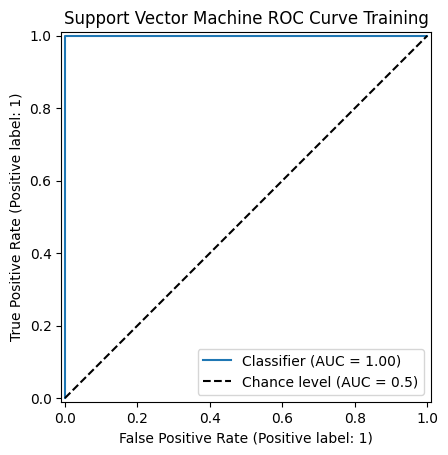

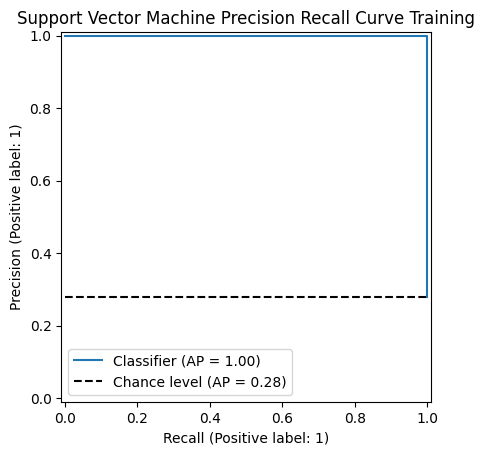

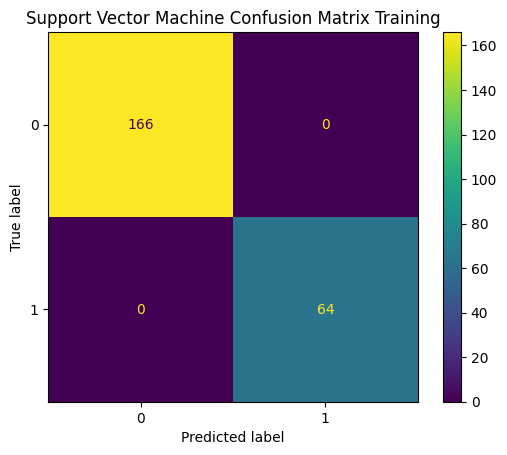

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       166
           1       1.00      1.00      1.00        64

    accuracy                           1.00       230
   macro avg       1.00      1.00      1.00       230
weighted avg       1.00      1.00      1.00       230

Mean accuracy (Validation): 0.85
Mean balanced accuracy(Validation):  0.7455197132616487
Mean roc auc(Validation):  0.8960573476702509


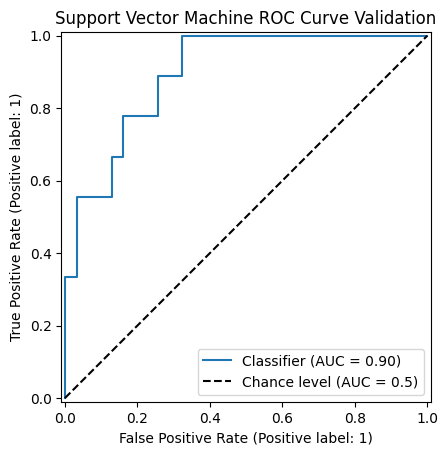

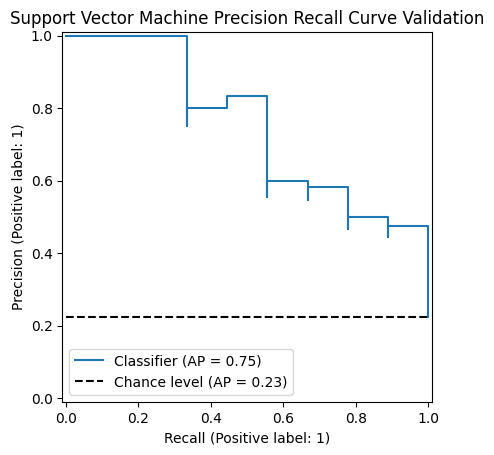

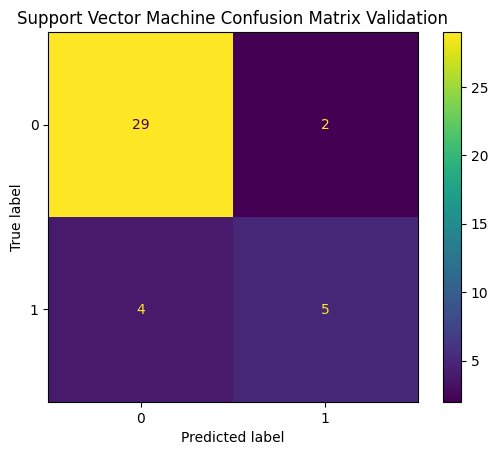

              precision    recall  f1-score   support

           0       0.88      0.94      0.91        31
           1       0.71      0.56      0.62         9

    accuracy                           0.85        40
   macro avg       0.80      0.75      0.77        40
weighted avg       0.84      0.85      0.84        40


{'C': 1, 'kernel': 'linear', 'shrinking': True, 'tol': 0.001}

In [75]:
grid_cv_params_linear = {
    'kernel': ['linear'],
    'tol': [0.001, 0.0001, 0.00001],
    'C': [1, 3, 5],
    'shrinking': [True, False],
}
grid_cv_res_linear = grid_search_cv(svc_params, grid_cv_params_linear)
grid_cv_res_linear.best_params_

### Grid Search CV for `rbf` (squared-exponential) kernel

Fitting 7 folds for each of 36 candidates, totalling 252 fits
_______________________________
Mean accuracy (Training): 0.8956521739130435
Mean balanced accuracy(Training):  0.8797063253012047
Mean roc auc(Training):  0.9695971385542169


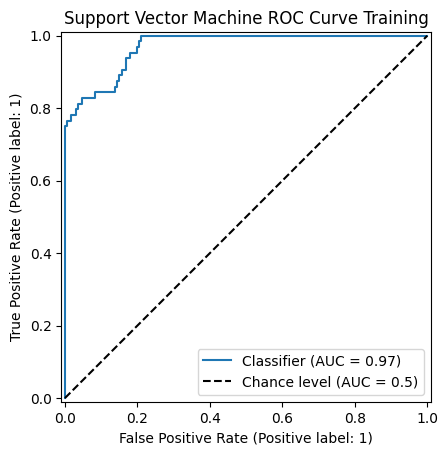

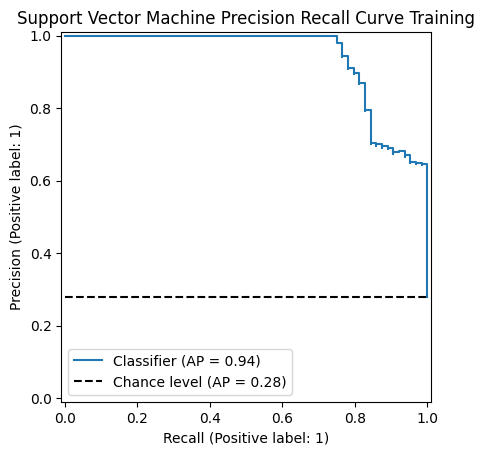

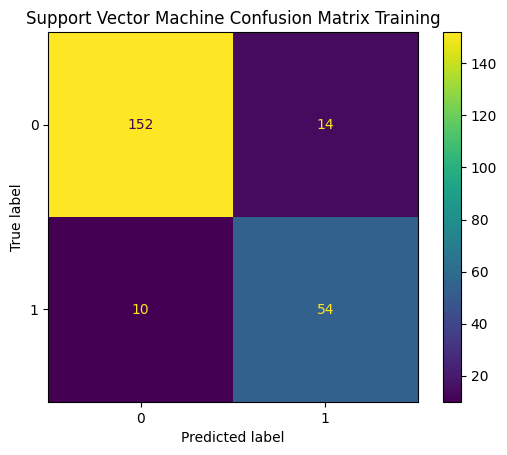

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       166
           1       0.79      0.84      0.82        64

    accuracy                           0.90       230
   macro avg       0.87      0.88      0.87       230
weighted avg       0.90      0.90      0.90       230

Mean accuracy (Validation): 0.85
Mean balanced accuracy(Validation):  0.7455197132616487
Mean roc auc(Validation):  0.8637992831541219


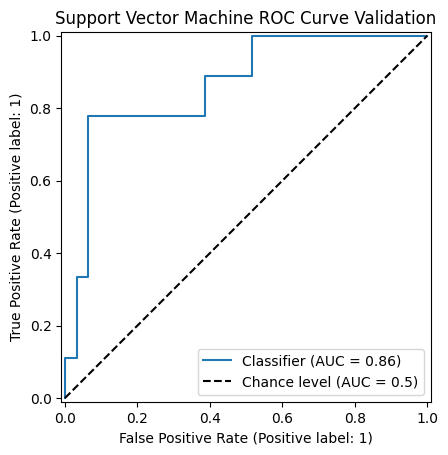

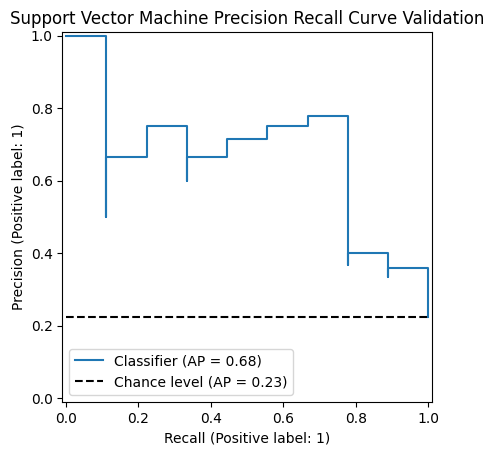

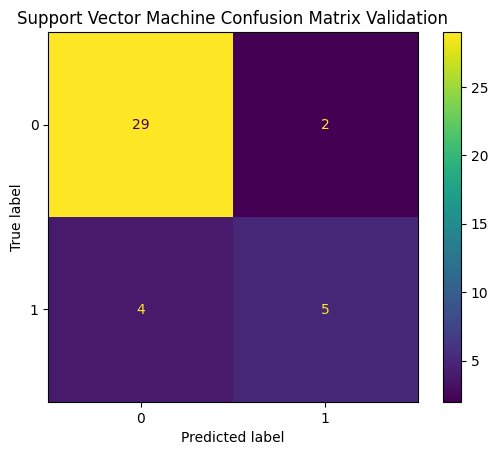

              precision    recall  f1-score   support

           0       0.88      0.94      0.91        31
           1       0.71      0.56      0.62         9

    accuracy                           0.85        40
   macro avg       0.80      0.75      0.77        40
weighted avg       0.84      0.85      0.84        40


{'C': 1, 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': True, 'tol': 0.001}

In [78]:
grid_cv_params_rbf = {
    'kernel': ['rbf'],
    'tol': [0.001, 0.0001, 0.00001],
    'C': [1, 3, 5],
    'shrinking': [True, False],
    'gamma': ['scale', 'auto'],  # only for kernel=['poly', 'rbf', 'sigmoid']
}
grid_cv_res_rbf = grid_search_cv(svc_params, grid_cv_params_rbf)
grid_cv_res_rbf.best_params_

Grid Search CV for `sigmoid` kernel

Fitting 7 folds for each of 144 candidates, totalling 1008 fits
_______________________________
Mean accuracy (Training): 0.8478260869565217
Mean balanced accuracy(Training):  0.8321724397590362
Mean roc auc(Training):  0.9037085843373494


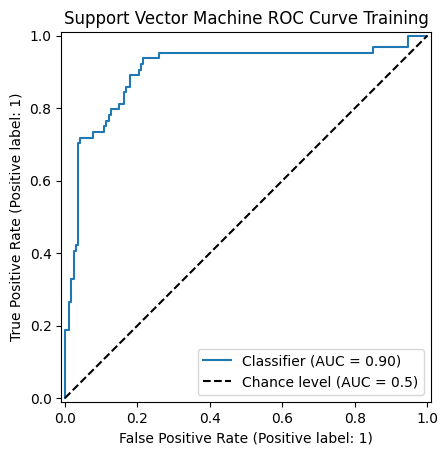

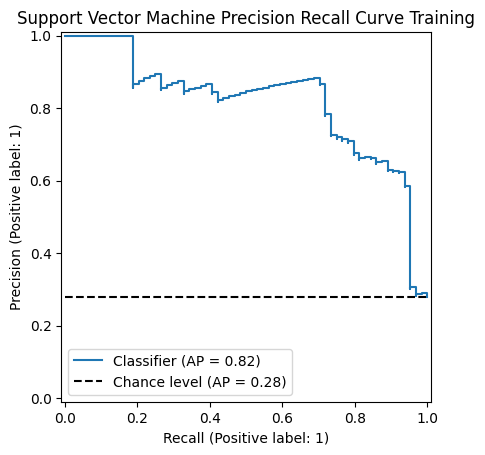

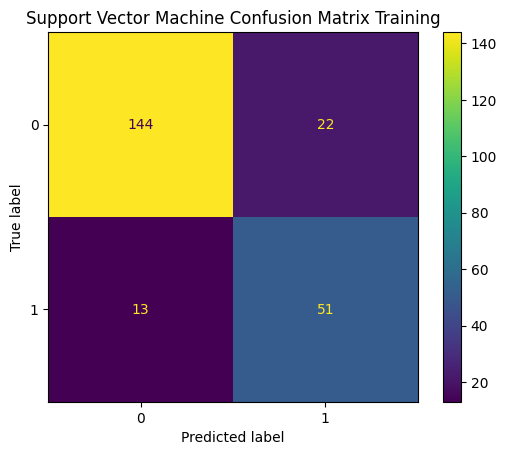

              precision    recall  f1-score   support

           0       0.92      0.87      0.89       166
           1       0.70      0.80      0.74        64

    accuracy                           0.85       230
   macro avg       0.81      0.83      0.82       230
weighted avg       0.86      0.85      0.85       230

Mean accuracy (Validation): 0.75
Mean balanced accuracy(Validation):  0.6810035842293907
Mean roc auc(Validation):  0.8243727598566308


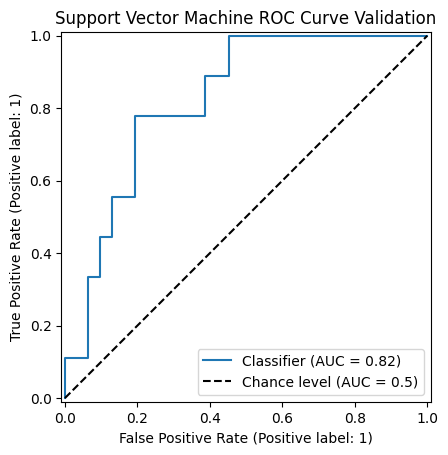

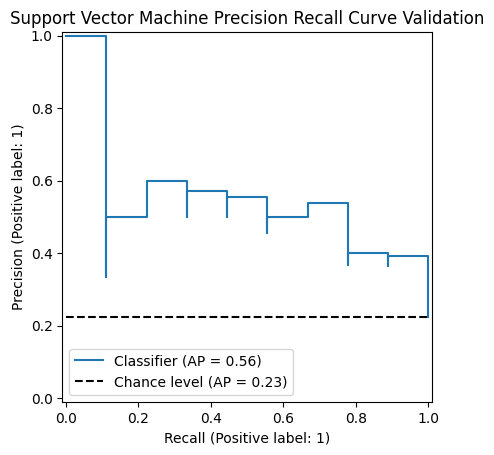

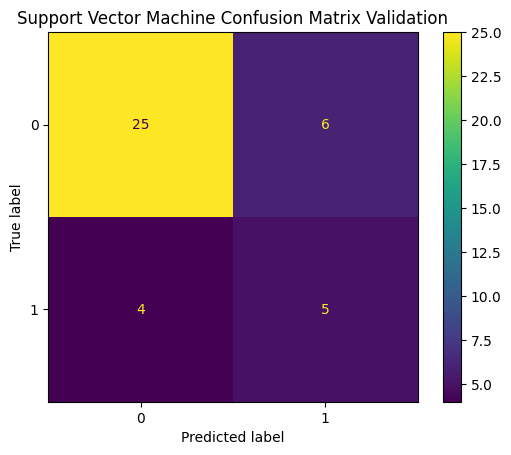

              precision    recall  f1-score   support

           0       0.86      0.81      0.83        31
           1       0.45      0.56      0.50         9

    accuracy                           0.75        40
   macro avg       0.66      0.68      0.67        40
weighted avg       0.77      0.75      0.76        40


{'C': 3,
 'coef0': 0.1,
 'gamma': 'scale',
 'kernel': 'sigmoid',
 'shrinking': True,
 'tol': 0.001}

In [79]:
grid_cv_params_sigmoid = {
    'kernel': ['sigmoid'],
    'tol': [0.001, 0.0001, 0.00001],
    'C': [1, 3, 5],
    'shrinking': [True, False],
    'gamma': ['scale', 'auto'],  # only for kernel=['poly', 'rbf', 'sigmoid']
    'coef0': [0.1, 0.5, 1, 3]  # only for kernel=['poly', 'sigmoid']
}
grid_cv_res_sigmoid = grid_search_cv(svc_params, grid_cv_params_sigmoid)
grid_cv_res_sigmoid.best_params_

### Grid Search CV for `poly` kernel

In [ ]:
grid_cv_params_poly = {
    'kernel': ['poly'],
    'tol': [0.001, 0.0001, 0.00001],
    'C': [1, 3, 5],
    'shrinking': [True, False],
    'degree': [2, 3, 4],  # only for kernel='poly' 
    'gamma': ['scale', 'auto'],  # only for kernel=['poly', 'rbf', 'sigmoid']
    'coef0': [0.5, 1, 3]  # only for kernel=['poly', 'sigmoid']
}
grid_cv_params_poly = grid_search_cv(svc_params, grid_cv_params_poly)
grid_cv_params_poly.best_params_

Fitting 7 folds for each of 432 candidates, totalling 3024 fits


Mean accuracy (Training): 1.0
Mean balanced accuracy(Training):  1.0
Mean roc auc(Training):  1.0


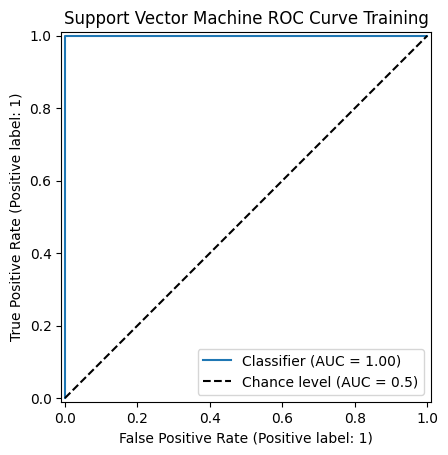

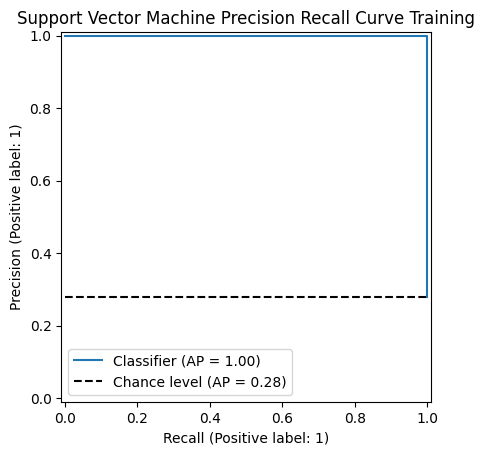

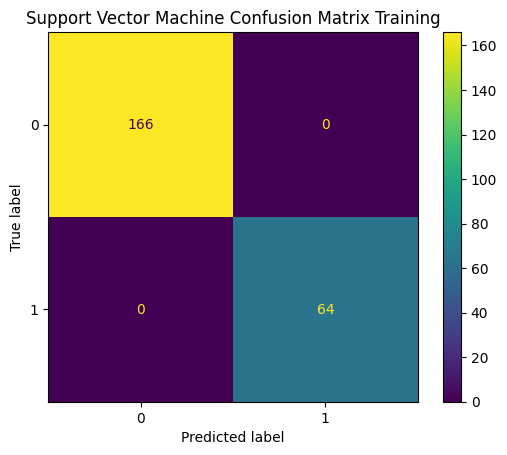

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       166
           1       1.00      1.00      1.00        64

    accuracy                           1.00       230
   macro avg       1.00      1.00      1.00       230
weighted avg       1.00      1.00      1.00       230

Mean accuracy (Validation): 0.85
Mean balanced accuracy(Validation):  0.7455197132616487
Mean roc auc(Validation):  0.899641577060932


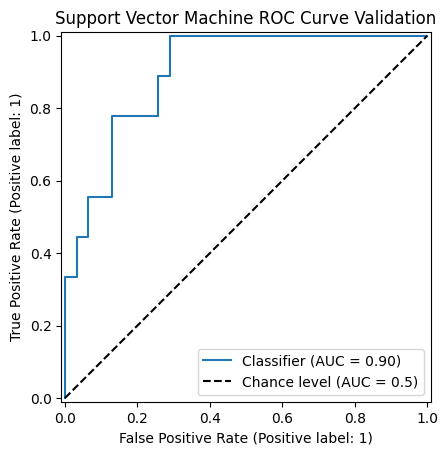

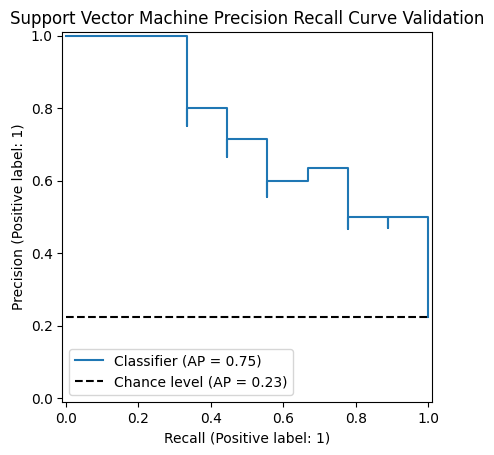

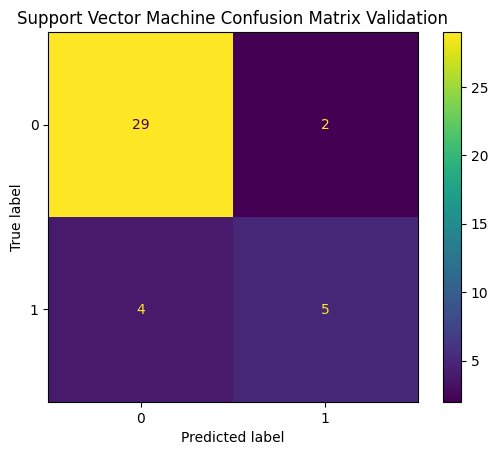

              precision    recall  f1-score   support

           0       0.88      0.94      0.91        31
           1       0.71      0.56      0.62         9

    accuracy                           0.85        40
   macro avg       0.80      0.75      0.77        40
weighted avg       0.84      0.85      0.84        40


{'C': 1,
 'coef0': 3,
 'degree': 2,
 'gamma': 'scale',
 'kernel': 'poly',
 'shrinking': True,
 'tol': 0.001}

In [82]:
svc_classifier_results_from_estimator(grid_cv_params_poly.best_estimator_)
grid_cv_params_poly.best_params_

### Additional searches for `poly` kernel

Fitting 7 folds for each of 48 candidates, totalling 336 fits
_______________________________
Mean accuracy (Training): 0.8217391304347826
Mean balanced accuracy(Training):  0.7900978915662651
Mean roc auc(Training):  0.8905308734939759


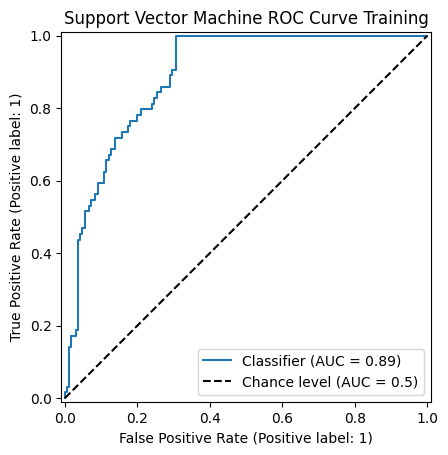

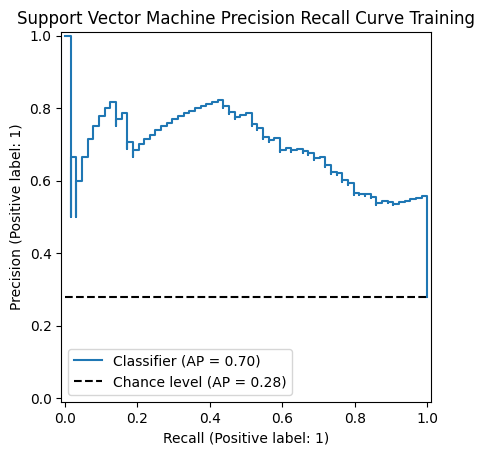

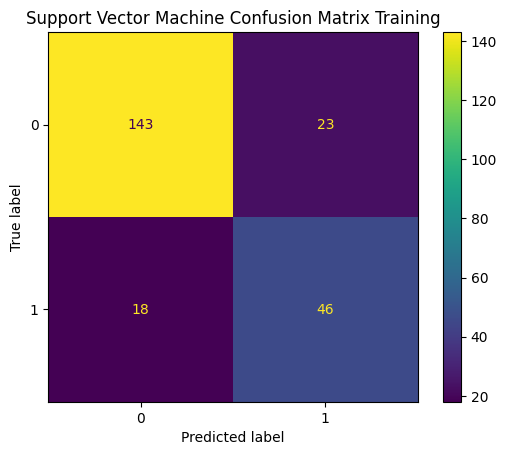

              precision    recall  f1-score   support

           0       0.89      0.86      0.87       166
           1       0.67      0.72      0.69        64

    accuracy                           0.82       230
   macro avg       0.78      0.79      0.78       230
weighted avg       0.83      0.82      0.82       230

Mean accuracy (Validation): 0.875
Mean balanced accuracy(Validation):  0.8010752688172043
Mean roc auc(Validation):  0.8709677419354839


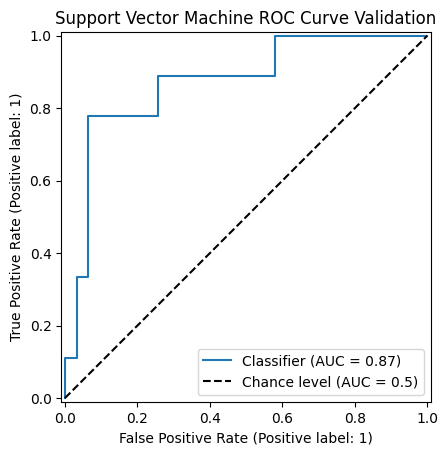

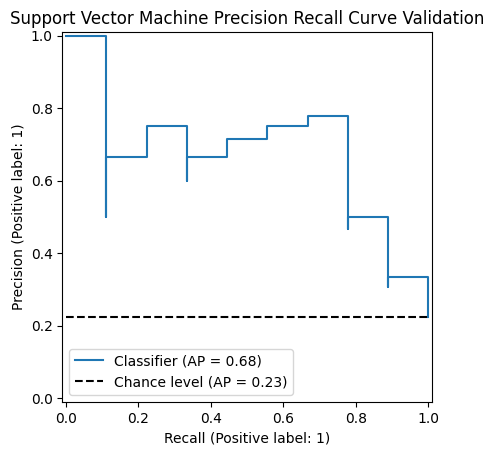

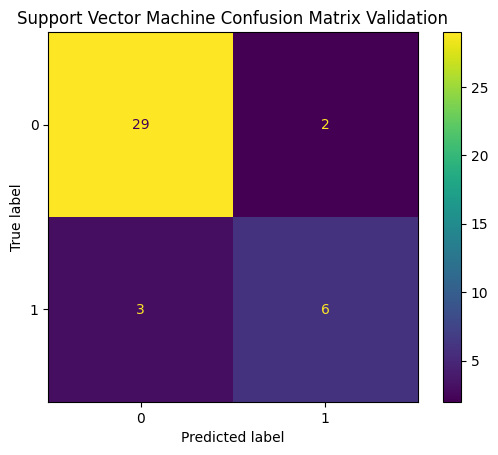

              precision    recall  f1-score   support

           0       0.91      0.94      0.92        31
           1       0.75      0.67      0.71         9

    accuracy                           0.88        40
   macro avg       0.83      0.80      0.81        40
weighted avg       0.87      0.88      0.87        40


{'C': 0.1,
 'coef0': 0.5,
 'degree': 1,
 'gamma': 'auto',
 'kernel': 'poly',
 'shrinking': True,
 'tol': 0.001}

In [23]:
grid_cv_params_poly_2 = {
    'kernel': ['poly'],
    'tol': [0.001],
    'C': [0.1, 0.5],
    'shrinking': [True],
    'degree': [1, 2, 3, 4],  # only for kernel='poly' 
    'gamma': ['scale', 'auto'],  # only for kernel=['poly', 'rbf', 'sigmoid']
    'coef0': [0.5, 1, 3]  # only for kernel=['poly', 'sigmoid']
}
grid_cv_params_poly_2 = grid_search_cv(svc_params, grid_cv_params_poly_2)
grid_cv_params_poly_2.best_params_

Fitting 7 folds for each of 80 candidates, totalling 560 fits
_______________________________
Mean accuracy (Training): 0.8217391304347826
Mean balanced accuracy(Training):  0.7900978915662651
Mean roc auc(Training):  0.8905308734939759


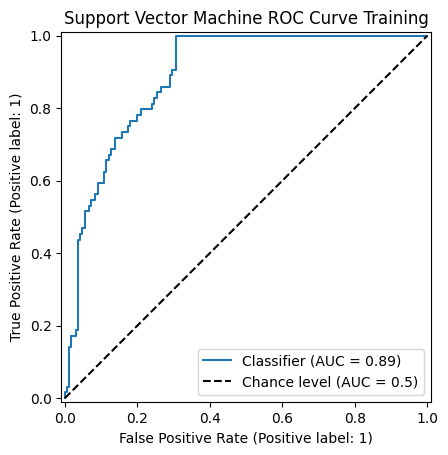

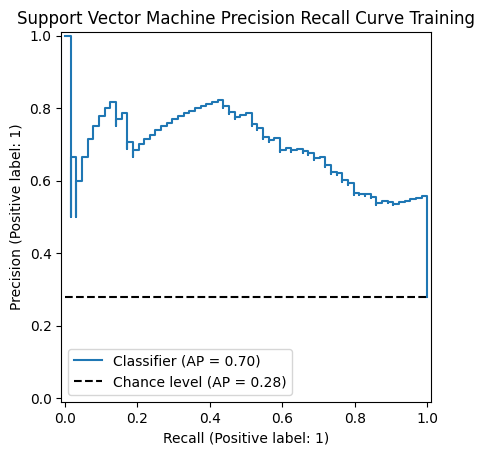

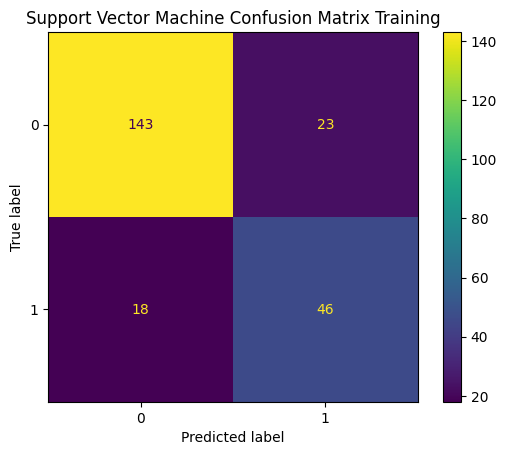

              precision    recall  f1-score   support

           0       0.89      0.86      0.87       166
           1       0.67      0.72      0.69        64

    accuracy                           0.82       230
   macro avg       0.78      0.79      0.78       230
weighted avg       0.83      0.82      0.82       230

Mean accuracy (Validation): 0.875
Mean balanced accuracy(Validation):  0.8010752688172043
Mean roc auc(Validation):  0.8709677419354839


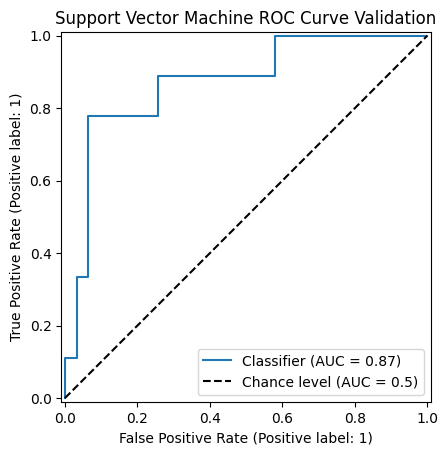

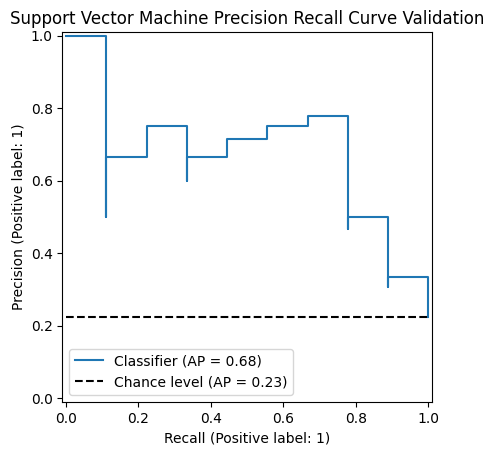

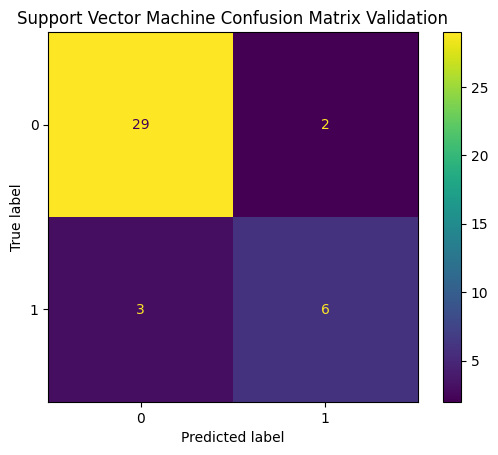

              precision    recall  f1-score   support

           0       0.91      0.94      0.92        31
           1       0.75      0.67      0.71         9

    accuracy                           0.88        40
   macro avg       0.83      0.80      0.81        40
weighted avg       0.87      0.88      0.87        40


{'C': 0.1,
 'coef0': -0.5,
 'degree': 1,
 'gamma': 'auto',
 'kernel': 'poly',
 'shrinking': True,
 'tol': 0.001}

In [27]:
grid_cv_params_poly_3 = {
    'kernel': ['poly'],
    'tol': [0.001, 0.0001],
    'C': [0.1, 0.5, 1, 3],
    'shrinking': [True],
    'degree': [1],  # only for kernel='poly' 
    'gamma': ['scale', 'auto'],  # only for kernel=['poly', 'rbf', 'sigmoid']
    'coef0': [-0.5, 0, 0.3, 0.5, 0.7]  # only for kernel=['poly', 'sigmoid']
}
grid_cv_params_poly_3 = grid_search_cv(svc_params, grid_cv_params_poly_3)
grid_cv_params_poly_3.best_params_

Fitting 7 folds for each of 40 candidates, totalling 280 fits
_______________________________
Mean accuracy (Training): 0.8217391304347826
Mean balanced accuracy(Training):  0.7900978915662651
Mean roc auc(Training):  0.8905308734939759


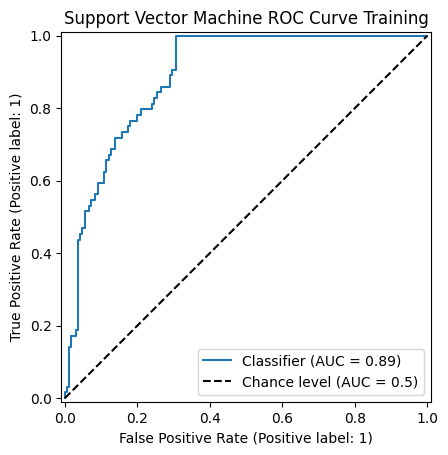

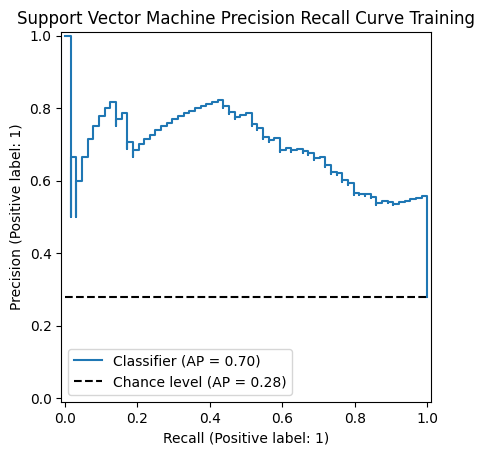

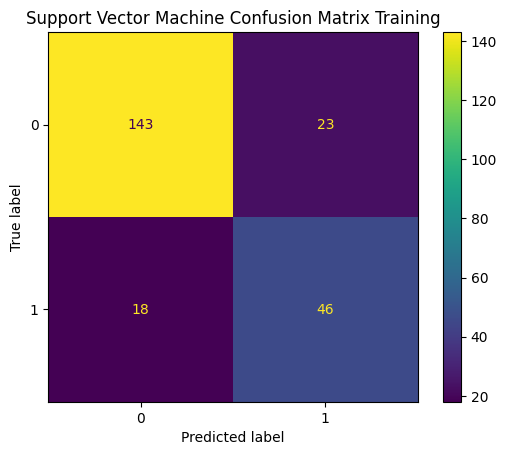

              precision    recall  f1-score   support

           0       0.89      0.86      0.87       166
           1       0.67      0.72      0.69        64

    accuracy                           0.82       230
   macro avg       0.78      0.79      0.78       230
weighted avg       0.83      0.82      0.82       230

Mean accuracy (Validation): 0.875
Mean balanced accuracy(Validation):  0.8010752688172043
Mean roc auc(Validation):  0.8709677419354839


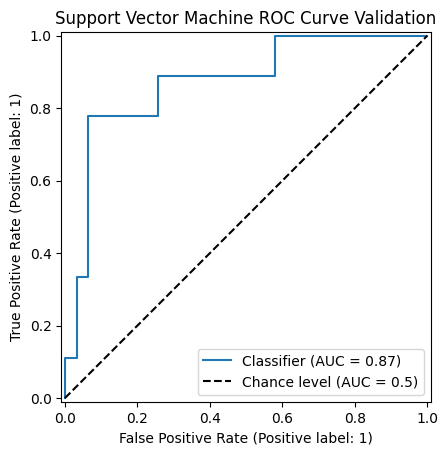

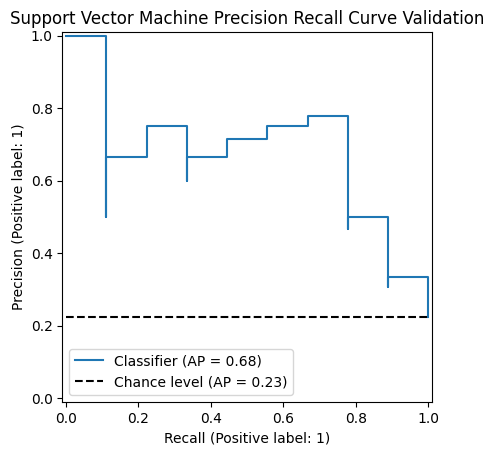

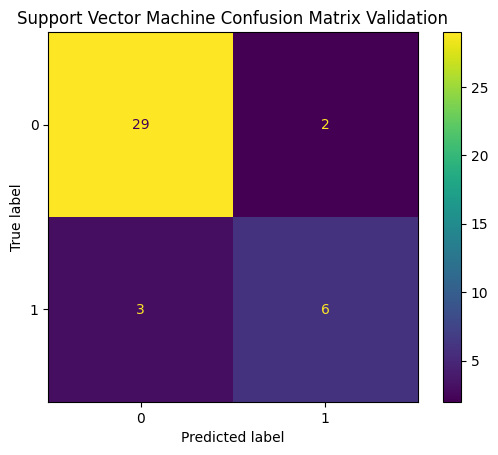

              precision    recall  f1-score   support

           0       0.91      0.94      0.92        31
           1       0.75      0.67      0.71         9

    accuracy                           0.88        40
   macro avg       0.83      0.80      0.81        40
weighted avg       0.87      0.88      0.87        40


{'C': 0.1,
 'coef0': 0,
 'degree': 1,
 'gamma': 'auto',
 'kernel': 'poly',
 'shrinking': True,
 'tol': 0.0001}

In [28]:
grid_cv_params_poly_4 = {
    'kernel': ['poly'],
    'tol': [0.0001],
    'C': [0.1, 0.3, 0.5, 1, 3],
    'shrinking': [True],
    'degree': [1],  # only for kernel='poly' 
    'gamma': ['scale', 'auto'],  # only for kernel=['poly', 'rbf', 'sigmoid']
    'coef0': [0, 0.3, 0.5, 0.7]  # only for kernel=['poly', 'sigmoid']
}
grid_cv_params_poly_4 = grid_search_cv(svc_params, grid_cv_params_poly_4)
grid_cv_params_poly_4.best_params_

Fitting 7 folds for each of 18 candidates, totalling 126 fits
_______________________________
Mean accuracy (Training): 0.9739130434782609
Mean balanced accuracy(Training):  0.9579254518072289
Mean roc auc(Training):  0.998117469879518


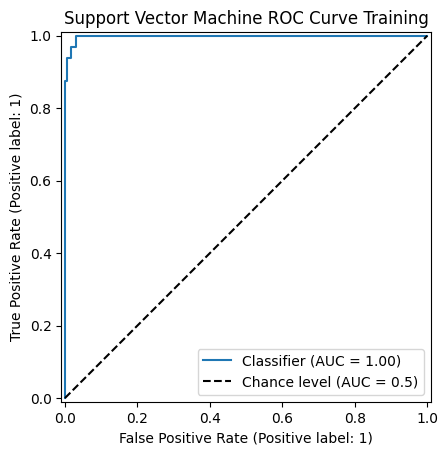

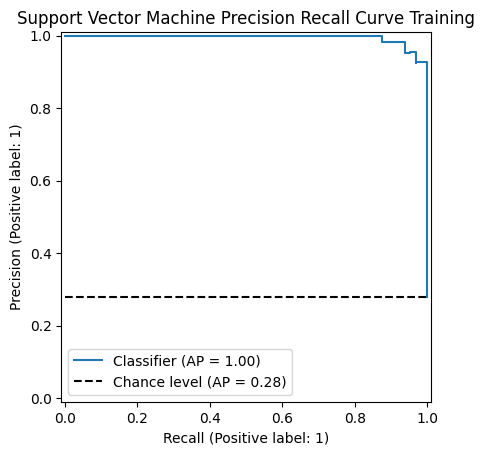

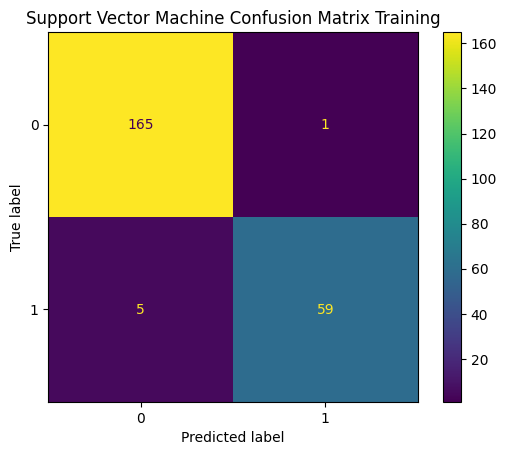

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       166
           1       0.98      0.92      0.95        64

    accuracy                           0.97       230
   macro avg       0.98      0.96      0.97       230
weighted avg       0.97      0.97      0.97       230

Mean accuracy (Validation): 0.85
Mean balanced accuracy(Validation):  0.7455197132616487
Mean roc auc(Validation):  0.881720430107527


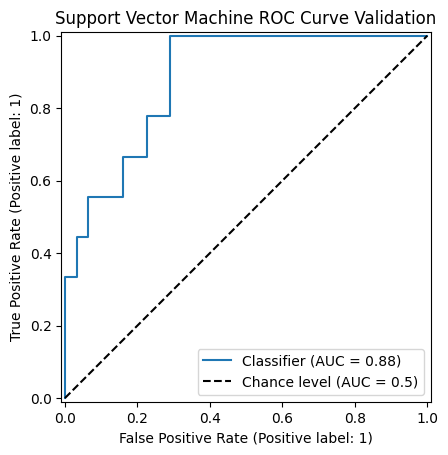

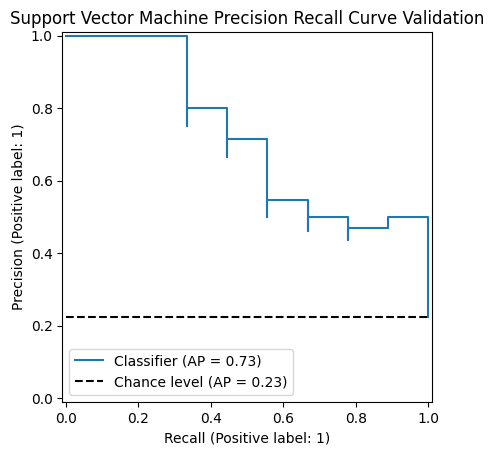

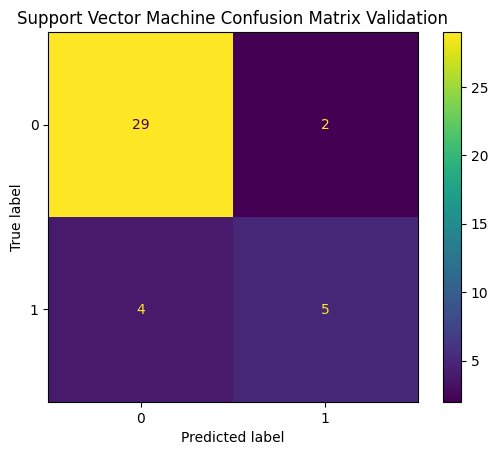

              precision    recall  f1-score   support

           0       0.88      0.94      0.91        31
           1       0.71      0.56      0.62         9

    accuracy                           0.85        40
   macro avg       0.80      0.75      0.77        40
weighted avg       0.84      0.85      0.84        40


{'C': 3,
 'coef0': 0.5,
 'degree': 1,
 'gamma': 'scale',
 'kernel': 'poly',
 'shrinking': True,
 'tol': 0.0001}

In [31]:
grid_cv_params_poly_5 = {
    'kernel': ['poly'],
    'tol': [0.0001],
    'C': [0.5, 1, 3],
    'shrinking': [True],
    'degree': [1],  # only for kernel='poly' 
    'gamma': ['scale', 'auto'],  # only for kernel=['poly', 'rbf', 'sigmoid']
    'coef0': [0.5, 1, 3]  # only for kernel=['poly', 'sigmoid']
}
grid_cv_params_poly_5 = grid_search_cv(svc_params, grid_cv_params_poly_5)
grid_cv_params_poly_5.best_params_

## Chosen model

Create a model with chosen params

Mean accuracy (Training): 1.0
Mean balanced accuracy(Training):  1.0
Mean roc auc(Training):  1.0


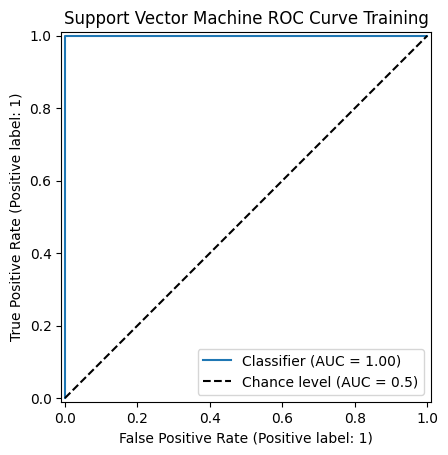

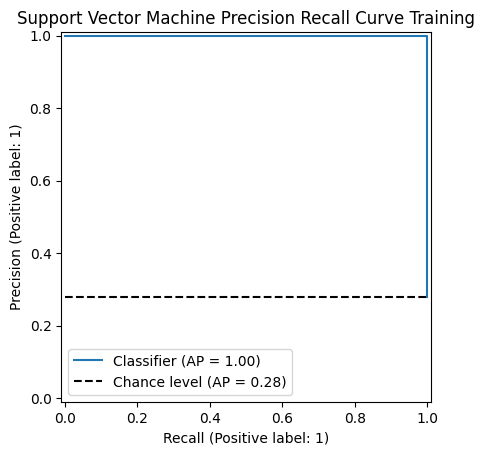

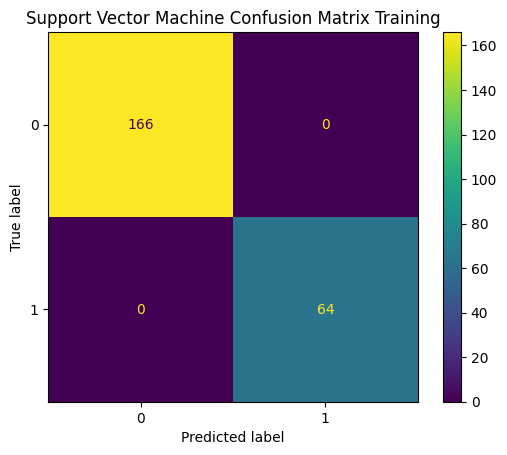

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       166
           1       1.00      1.00      1.00        64

    accuracy                           1.00       230
   macro avg       1.00      1.00      1.00       230
weighted avg       1.00      1.00      1.00       230

Mean accuracy (Validation): 0.85
Mean balanced accuracy(Validation):  0.7455197132616487
Mean roc auc(Validation):  0.899641577060932


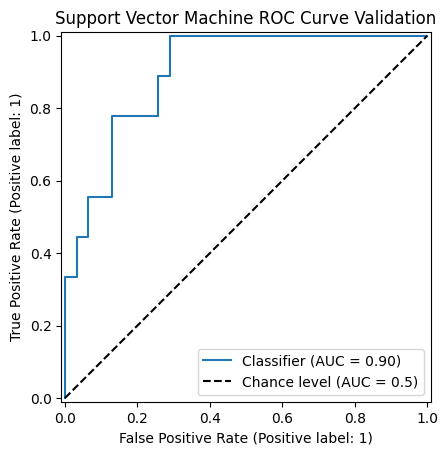

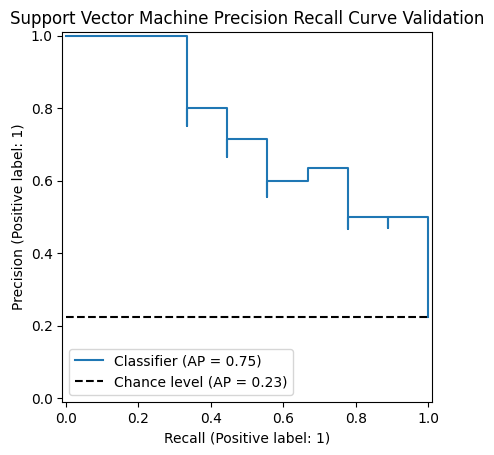

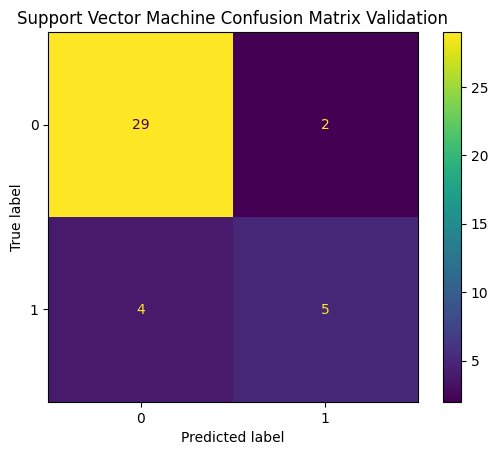

              precision    recall  f1-score   support

           0       0.88      0.94      0.91        31
           1       0.71      0.56      0.62         9

    accuracy                           0.85        40
   macro avg       0.80      0.75      0.77        40
weighted avg       0.84      0.85      0.84        40


In [13]:
chosen_params = {
    'C': 1,
    'coef0': 3,
    'degree': 2,
    'gamma': 'scale',
    'kernel': 'poly',
    'shrinking': True,
    'tol': 0.001
}
chosen_model = svc_classifier_results({**svc_params, **chosen_params})

Save the chosen model

In [14]:
joblib.dump(chosen_model, os.path.join(os.pardir, 'models', 'svm_model.joblib'))

['..\\models\\svm_model.joblib']

## Check test results
Download the model if is not defined

In [15]:
if 'chosen_model' in globals():
    chosen_model = joblib.load(os.path.join(os.pardir, 'models', 'svm_model.joblib'), 'r')

Define a test function

In [16]:
def svc_classifier_test(svc, X_test_csr, y_test) -> None:
    y_test_pred = svc.predict(X_test_csr)
    y_test_pred_proba = svc.predict_proba(X_test_csr)[:,1]
    classifier_results("SVM", "Independent Testing", y_test, y_test_pred, y_test_pred_proba)

Load the test data

In [18]:
store = pd.HDFStore(os.path.join(os.pardir, 'data', 'ctc_split_datasets.h5'), mode='r')

X_test, y_test = store["X_test"], store["y_test"]
X_test_csr = csr_matrix(X_test.astype(np.float32))

store.close()
del store

Check results on test data

Mean accuracy (Independent Testing): 0.8378378378378378
Mean balanced accuracy(Independent Testing):  0.6702586206896552
Mean roc auc(Independent Testing):  0.8663793103448276


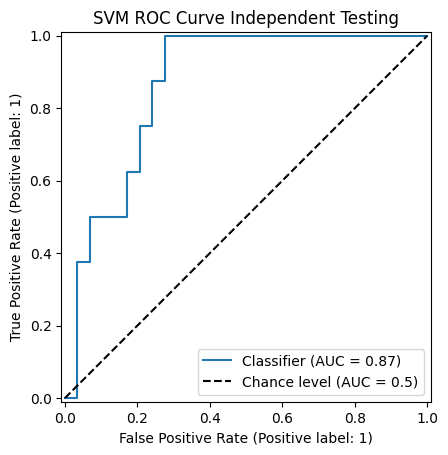

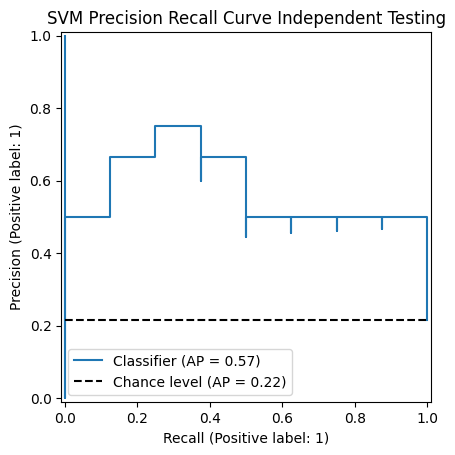

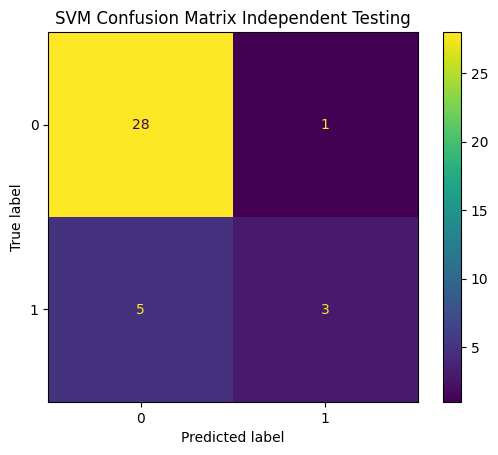

              precision    recall  f1-score   support

           0       0.85      0.97      0.90        29
           1       0.75      0.38      0.50         8

    accuracy                           0.84        37
   macro avg       0.80      0.67      0.70        37
weighted avg       0.83      0.84      0.82        37


In [19]:
svc_classifier_test(chosen_model, X_test_csr, y_test)